In [1]:
using Plots, Printf, DelimitedFiles, BenchmarkTools, FFTW, CuArrays
using Revise
using MDToolbox
ENV["COLUMNS"] = 130

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /opt/julia_depot/packages/Revise/C272c/src/Revise.jl:1219
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


130

In [2]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_36864_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
decenter!(model_array);

In [3]:
for iatom = 1:model_array.natom
    push!(model_array.mass, MDToolbox.defaultParameters()[model_array.resname[iatom]])
end
model_array.mass'

1×1044 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 2.8  2.6  2.95  3.2  3.05  3.1  3.3  2.25  2.8  3.25  3.1  …  2.6  2.6  3.1  3.3  2.6  2.85  2.6  2.75  3.1  2.5  2.8  2.6

In [4]:
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end

In [5]:
model_array.natom

1044

In [6]:
pdbRotated = MDToolbox.rotate(model_array[1, :], q_array[7, :])

1x1044 TrjArray{Float64,Int64}
| X                          | X                          |  …   X                          | X                          |
| 1THR                       | 2SER                       |  …   1043PRO                    | 1044SER                    |
| 1THR                       | 2SER                       |  …   1043PRO                    | 1044SER                    |
|   -35.48   -14.16     1.18 |   -36.19   -11.12     3.81 |  …      54.09    -5.23    35.45 |    56.93    -5.20    32.97 |

In [10]:
param = AfmizeConfig(10.0 * (pi / 180), 10.0, MDToolbox.Point2D(-250, -200), MDToolbox.Point2D(250, 200), MDToolbox.Point2D(6.25, 6.25), MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 10.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))

  0.950240 seconds (32.13 M allocations: 490.392 MiB, 10.53% gc time)


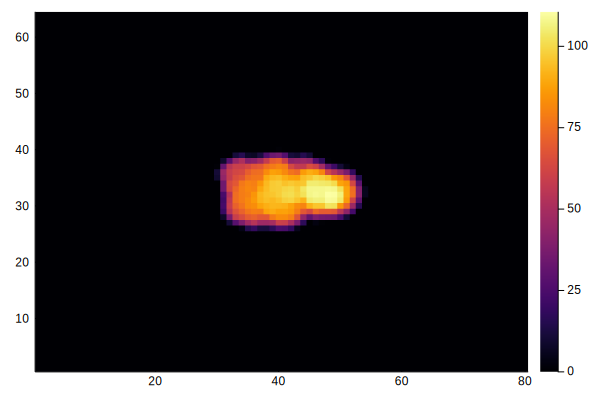

In [104]:
@time calculated = MDToolbox.afmize_beta(pdbRotated, param)
heatmap(calculated)

In [37]:
pdbRotated_gpu = gpu32(pdbRotated)
pdbRotated_gpu.x

1×1044 CuArray{Float32,2,Nothing}:
 -35.481  -36.188  -33.7642  -31.1571  -33.9318  -36.9978  -38.091  …  47.6453  49.9506  49.4848  51.1395  54.0924  56.9318

typeof(s) = CuArray{Float64,2,Nothing}
typeof(index_collide) = CuArray{Bool,2,Nothing}


┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /opt/julia_depot/packages/GPUArrays/QDGmr/src/host/indexing.jl:43


  0.165138 seconds (8.47 k CPU allocations: 107.579 MiB) (50 GPU allocations: 454.643 MiB, 0.08% gc time)


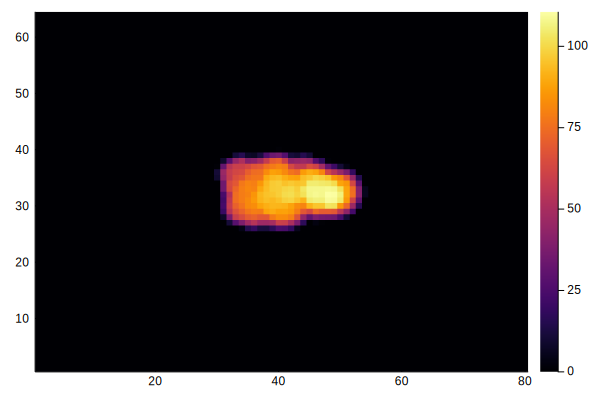

In [105]:
CuArrays.allowscalar(true)
CuArrays.@time calculated2 = MDToolbox.afmize_gpu(pdbRotated_gpu, param)
heatmap(Array(calculated2))

In [106]:
calculated

64×80 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0

In [107]:
calculated2

64×80 CuArray{Float32,2,CuArray{Float32,2,Nothing}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

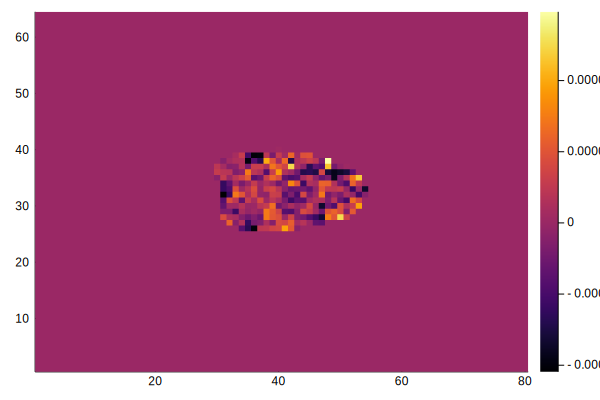

In [110]:
heatmap(calculated .- Array(calculated2))